# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_curve, auc, precision_score, average_precision_score, balanced_accuracy_score, log_loss, plot_confusion_matrix, f1_score, roc_auc_score, roc_curve, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from joblib import Parallel, delayed
from sklearn.datasets import make_classification
from copy import deepcopy

/Users/bkarami/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Config

In [2]:
# Matplotlib styling
mpl.style.use("seaborn-white")

# For parallel processing
N_CORES = 8

# Random classification data generator
N_SAMPLES = 5000
WEIGHTS = [0.95, 0.05]

# Number of 1s required in oversampled data
N_ROWS_1 = 2000

# Generating imbalanced classification dataset

In [3]:
X, y = make_classification(
    n_samples=N_SAMPLES, n_classes=2, 
    weights=WEIGHTS, flip_y=0, random_state=1)

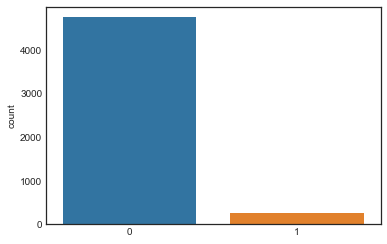

In [4]:
sns.countplot(y)
plt.show()

# Random Oversampling

In [5]:
# Random oversampling
def oversample_random(X, y, rows_1, random_state):
    '''Accepts X and y arrays along with the number of
    required positively labeled samples (rows_1). Returns
    randomly oversampled positively labeled data.
    '''
    X_random, y_random = RandomOverSampler(
        sampling_strategy={1: rows_1},
        random_state=random_state
    ).fit_resample(X_train, y_train)
    
    return X_random, y_random

# SMOTE

In [6]:
# SMOTE
def oversample_smote(X, y, rows_1, k_neighbors, random_state):
    '''Accepts X and y arrays along with the number of
    required positively labeled samples (rows_1) and number
    of nearest neighbors to consider in the SMOTE algorithm. 
    Returns SMOTE oversampled positively labeled data.
    '''
    X_smote, y_smote = SMOTE(
        sampling_strategy={1: rows_1},
        k_neighbors=k_neighbors,
        random_state=random_state
    ).fit_resample(X, y)
    
    return X_smote, y_smote

# Crossover

In [7]:
# Single crossover point oversampling
def oversample_crossover(X, y, rows_1, mode="single", knn=False, random_state=1):
    '''Oversampled positively labeled data using a crossover
    operation. 
    
    Args: 
        X: Array of explanatory variables to oversample data from
        y: Array of labels associated with X
        rows_1: Number of positively labled rows required (original + oversampled)
        mode: Choice between single-point ("single"), two-point ("two"), and
            uniform ("uniform") crossover operation
        knn: If set to True, drops oversampled data whose nearest neighbor is not
            positively labeled.
        random_state: random state to pass to ensure reproducability of results
        
    Returns:
        X_crossover: Array of explanatory variables associated with the new 
            oversampled data (includes original + new data)
        y_crossover: Labels associated with X_crossover
    '''
    np.random.seed(random_state)

    # Potential because if the knn parameter is set to True,
    # those samples need to be checked if their nearest neighbor
    # has a label of 1
    potential_samples = []

    X_positive = X[y==1]
    no_rows = X_positive.shape[0]
    no_cols = X_positive.shape[1]

    # assume % of 1s is at least 3%, this is relevant if knn=True
    for i in range(int(rows_1/0.03)): 
        parent_1 = np.random.randint(0, no_rows)
        parent_2 = np.random.randint(0, no_rows)
        
        if mode=="single":
            cross_point = np.random.randint(1, no_cols)
            mask = np.array([1 if col_no < cross_point else 0 
                    for col_no in range(no_cols)])
        
        elif mode=="two":
            cross_point_1 = np.random.randint(1, no_cols-1)
            cross_point_2 = np.random.randint(cross_point_1, no_cols-1)
            mask = np.array([
                1 if col_no < cross_point_1 or col_no > cross_point_2
                else 0 for col_no in range(no_cols)])
            
        elif mode=="uniform":
            mask = np.random.randint(0, 2, no_cols)
            
        else:
            raise ValueError("Accebtable options for mode: single, two, uniform")
        
        potential_samples.append(
              (X_positive[parent_1] * mask)
            + (X_positive[parent_2] * (1-mask))
        )

    if knn == False:
        X_crossover = potential_samples
    else:
        scaler = MinMaxScaler().fit(X)
        X_scaled = scaler.transform(X)
        potential_samples_scaled = scaler.transform(potential_samples)

        model = KNeighborsClassifier(n_neighbors=1)
        model.fit(X_scaled, y)

        knn_filter = (model.predict_proba(
            potential_samples_scaled)[:, 1] > 0
        )

        X_crossover = np.array(potential_samples)[
            knn_filter]

    required_rows = rows_1 - (y==1).sum()

    X_crossover = np.vstack([X, X_crossover[:required_rows]])

    y_crossover = np.hstack([
        y, np.ones(required_rows)])
    
    return X_crossover, y_crossover

# Evaluation

In [8]:
metrics_dict = {"ROC AUC": [],
              "PR AUC": [],
              "Balanced Accuracy": [],
              "Max F1": [],
              "Recall": [],
              "Precision": [],
              "F1": []
               }
results_original = deepcopy(metrics_dict)
results_random = deepcopy(metrics_dict)
results_smote_1 = deepcopy(metrics_dict)
results_smote_3 = deepcopy(metrics_dict)
results_smote_5 = deepcopy(metrics_dict)
results_smote_10 = deepcopy(metrics_dict)
results_singlex = deepcopy(metrics_dict)
results_singlex_knn = deepcopy(metrics_dict)
results_twox = deepcopy(metrics_dict)
results_twox_knn = deepcopy(metrics_dict)
results_uniformx = deepcopy(metrics_dict)
results_uniformx_knn = deepcopy(metrics_dict)


for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)
    
    clf = RandomForestClassifier(random_state=i)
    
    X_random, y_random = oversample_random(X_train, y_train, N_ROWS_1, i)
    X_smote_1, y_smote_1 = oversample_smote(X_train, y_train, N_ROWS_1, 1, i)
    X_smote_3, y_smote_3 = oversample_smote(X_train, y_train, N_ROWS_1, 3, i)
    X_smote_5, y_smote_5 = oversample_smote(X_train, y_train, N_ROWS_1, 5, i)
    X_smote_10, y_smote_10 = oversample_smote(X_train, y_train, N_ROWS_1, 10, i)
    X_singlex, y_singlex = oversample_crossover(
        X_train, y_train, N_ROWS_1, mode="single", knn=False, random_state=i)
    X_singlex_knn, y_singlex_knn = oversample_crossover(
        X_train, y_train, N_ROWS_1, mode="single", knn=True, random_state=i)
    X_twox, y_twox = oversample_crossover(
        X_train, y_train, N_ROWS_1, mode="two", knn=False, random_state=i)
    X_twox_knn, y_twox_knn = oversample_crossover(
        X_train, y_train, N_ROWS_1, mode="two", knn=True, random_state=i)
    X_uniformx, y_uniformx = oversample_crossover(
        X_train, y_train, N_ROWS_1, mode="uniform", knn=False, random_state=i)
    X_uniformx_knn, y_uniformx_knn = oversample_crossover(
        X_train, y_train, N_ROWS_1, mode="uniform", knn=True, random_state=i)
    
    model = clf.fit(X_train, y_train)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision_, recall_, _ = precision_recall_curve(
        y_test, model.predict_proba(X_test)[:, 1])
    f1_ = (2*precision_*recall_) / (recall_+precision_)
    pr_auc = auc(recall_, precision_)
    max_f1 = np.max(f1_)
    recall = recall_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    balanced_accuracy = balanced_accuracy_score(y_test, model.predict(X_test))
    results_original["ROC AUC"].append(roc_auc)
    results_original["PR AUC"].append(pr_auc)
    results_original["Max F1"].append(max_f1)
    results_original["Balanced Accuracy"].append(balanced_accuracy)
    results_original["Recall"].append(recall)
    results_original["Precision"].append(precision)
    results_original["F1"].append(f1)
    
    model = clf.fit(X_random, y_random)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision_, recall_, _ = precision_recall_curve(
        y_test, model.predict_proba(X_test)[:, 1])
    f1_ = (2*precision_*recall_) / (recall_+precision_) 
    pr_auc = auc(recall_, precision_)
    max_f1 = np.max(f1_)
    recall = recall_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    balanced_accuracy = balanced_accuracy_score(y_test, model.predict(X_test))
    results_random["ROC AUC"].append(roc_auc)
    results_random["PR AUC"].append(pr_auc)
    results_random["Max F1"].append(max_f1)
    results_random["Balanced Accuracy"].append(balanced_accuracy)
    results_random["Recall"].append(recall)
    results_random["Precision"].append(precision)
    results_random["F1"].append(f1)

    model = clf.fit(X_smote_1, y_smote_1)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision_, recall_, _ = precision_recall_curve(
        y_test, model.predict_proba(X_test)[:, 1])
    f1_ = (2*precision_*recall_) / (recall_+precision_) 
    pr_auc = auc(recall_, precision_)
    max_f1 = np.max(f1_)
    recall = recall_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    balanced_accuracy = balanced_accuracy_score(y_test, model.predict(X_test))
    results_smote_1["ROC AUC"].append(roc_auc)
    results_smote_1["PR AUC"].append(pr_auc)
    results_smote_1["Max F1"].append(max_f1)
    results_smote_1["Balanced Accuracy"].append(balanced_accuracy)
    results_smote_1["Recall"].append(recall)
    results_smote_1["Precision"].append(precision)
    results_smote_1["F1"].append(f1)
    
    model = clf.fit(X_smote_3, y_smote_3)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision_, recall_, _ = precision_recall_curve(
        y_test, model.predict_proba(X_test)[:, 1])
    f1_ = (2*precision_*recall_) / (recall_+precision_) 
    pr_auc = auc(recall_, precision_)
    max_f1 = np.max(f1_)
    recall = recall_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    balanced_accuracy = balanced_accuracy_score(y_test, model.predict(X_test))
    results_smote_3["ROC AUC"].append(roc_auc)
    results_smote_3["PR AUC"].append(pr_auc)
    results_smote_3["Max F1"].append(max_f1)
    results_smote_3["Balanced Accuracy"].append(balanced_accuracy)
    results_smote_3["Recall"].append(recall)
    results_smote_3["Precision"].append(precision)
    results_smote_3["F1"].append(f1)
    
    model = clf.fit(X_smote_5, y_smote_5)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision_, recall_, _ = precision_recall_curve(
        y_test, model.predict_proba(X_test)[:, 1])
    f1_ = (2*precision_*recall_) / (recall_+precision_) 
    pr_auc = auc(recall_, precision_)
    max_f1 = np.max(f1_)
    recall = recall_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    balanced_accuracy = balanced_accuracy_score(y_test, model.predict(X_test))
    results_smote_5["ROC AUC"].append(roc_auc)
    results_smote_5["PR AUC"].append(pr_auc)
    results_smote_5["Max F1"].append(max_f1)
    results_smote_5["Balanced Accuracy"].append(balanced_accuracy)
    results_smote_5["Recall"].append(recall)
    results_smote_5["Precision"].append(precision)
    results_smote_5["F1"].append(f1)
    
    model = clf.fit(X_smote_10, y_smote_10)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision_, recall_, _ = precision_recall_curve(
        y_test, model.predict_proba(X_test)[:, 1])
    f1_ = (2*precision_*recall_) / (recall_+precision_) 
    pr_auc = auc(recall_, precision_)
    max_f1 = np.max(f1_)
    recall = recall_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    balanced_accuracy = balanced_accuracy_score(y_test, model.predict(X_test))
    results_smote_10["ROC AUC"].append(roc_auc)
    results_smote_10["PR AUC"].append(pr_auc)
    results_smote_10["Max F1"].append(max_f1)
    results_smote_10["Balanced Accuracy"].append(balanced_accuracy)
    results_smote_10["Recall"].append(recall)
    results_smote_10["Precision"].append(precision)
    results_smote_10["F1"].append(f1)
    
    model = clf.fit(X_singlex, y_singlex)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision_, recall_, _ = precision_recall_curve(
        y_test, model.predict_proba(X_test)[:, 1])
    f1_ = (2*precision_*recall_) / (recall_+precision_) 
    pr_auc = auc(recall_, precision_)
    max_f1 = np.max(f1_)
    recall = recall_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    balanced_accuracy = balanced_accuracy_score(y_test, model.predict(X_test))
    results_singlex["ROC AUC"].append(roc_auc)
    results_singlex["PR AUC"].append(pr_auc)
    results_singlex["Max F1"].append(max_f1)
    results_singlex["Balanced Accuracy"].append(balanced_accuracy)
    results_singlex["Recall"].append(recall)
    results_singlex["Precision"].append(precision)
    results_singlex["F1"].append(f1)
    
    model = clf.fit(X_singlex_knn, y_singlex_knn)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision_, recall_, _ = precision_recall_curve(
        y_test, model.predict_proba(X_test)[:, 1])
    f1_ = (2*precision_*recall_) / (recall_+precision_) 
    pr_auc = auc(recall_, precision_)
    max_f1 = np.max(f1_)
    recall = recall_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    balanced_accuracy = balanced_accuracy_score(y_test, model.predict(X_test))
    results_singlex_knn["ROC AUC"].append(roc_auc)
    results_singlex_knn["PR AUC"].append(pr_auc)
    results_singlex_knn["Max F1"].append(max_f1)
    results_singlex_knn["Balanced Accuracy"].append(balanced_accuracy)
    results_singlex_knn["Recall"].append(recall)
    results_singlex_knn["Precision"].append(precision)
    results_singlex_knn["F1"].append(f1)

    model = clf.fit(X_twox, y_twox)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision_, recall_, _ = precision_recall_curve(
        y_test, model.predict_proba(X_test)[:, 1])
    f1_ = (2*precision_*recall_) / (recall_+precision_) 
    pr_auc = auc(recall_, precision_)
    max_f1 = np.max(f1_)
    recall = recall_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    balanced_accuracy = balanced_accuracy_score(y_test, model.predict(X_test))
    results_twox["ROC AUC"].append(roc_auc)
    results_twox["PR AUC"].append(pr_auc)
    results_twox["Max F1"].append(max_f1)
    results_twox["Balanced Accuracy"].append(balanced_accuracy)
    results_twox["Recall"].append(recall)
    results_twox["Precision"].append(precision)
    results_twox["F1"].append(f1)
    
    model = clf.fit(X_twox_knn, y_twox_knn)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision_, recall_, _ = precision_recall_curve(
        y_test, model.predict_proba(X_test)[:, 1])
    f1_ = (2*precision_*recall_) / (recall_+precision_) 
    pr_auc = auc(recall_, precision_)
    max_f1 = np.max(f1_)
    recall = recall_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    balanced_accuracy = balanced_accuracy_score(y_test, model.predict(X_test))
    results_twox_knn["ROC AUC"].append(roc_auc)
    results_twox_knn["PR AUC"].append(pr_auc)
    results_twox_knn["Max F1"].append(max_f1)
    results_twox_knn["Balanced Accuracy"].append(balanced_accuracy)
    results_twox_knn["Recall"].append(recall)
    results_twox_knn["Precision"].append(precision)
    results_twox_knn["F1"].append(f1)
    
    model = clf.fit(X_uniformx, y_uniformx)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision_, recall_, _ = precision_recall_curve(
        y_test, model.predict_proba(X_test)[:, 1])
    f1_ = (2*precision_*recall_) / (recall_+precision_) 
    pr_auc = auc(recall_, precision_)
    max_f1 = np.max(f1_)
    recall = recall_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    balanced_accuracy = balanced_accuracy_score(y_test, model.predict(X_test))
    results_uniformx["ROC AUC"].append(roc_auc)
    results_uniformx["PR AUC"].append(pr_auc)
    results_uniformx["Max F1"].append(max_f1)
    results_uniformx["Balanced Accuracy"].append(balanced_accuracy)
    results_uniformx["Recall"].append(recall)
    results_uniformx["Precision"].append(precision)
    results_uniformx["F1"].append(f1)
    
    model = clf.fit(X_uniformx_knn, y_uniformx_knn)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision_, recall_, _ = precision_recall_curve(
        y_test, model.predict_proba(X_test)[:, 1])
    f1_ = (2*precision_*recall_) / (recall_+precision_) 
    pr_auc = auc(recall_, precision_)
    max_f1 = np.max(f1_)
    recall = recall_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    balanced_accuracy = balanced_accuracy_score(y_test, model.predict(X_test))
    results_uniformx_knn["ROC AUC"].append(roc_auc)
    results_uniformx_knn["PR AUC"].append(pr_auc)
    results_uniformx_knn["Max F1"].append(max_f1)
    results_uniformx_knn["Balanced Accuracy"].append(balanced_accuracy)
    results_uniformx_knn["Recall"].append(recall)
    results_uniformx_knn["Precision"].append(precision)
    results_uniformx_knn["F1"].append(f1)

/Users/bkarami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in true_divide
/Users/bkarami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in true_divide
/Users/bkarami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:145: RuntimeWarning: invalid value encountered in true_divide


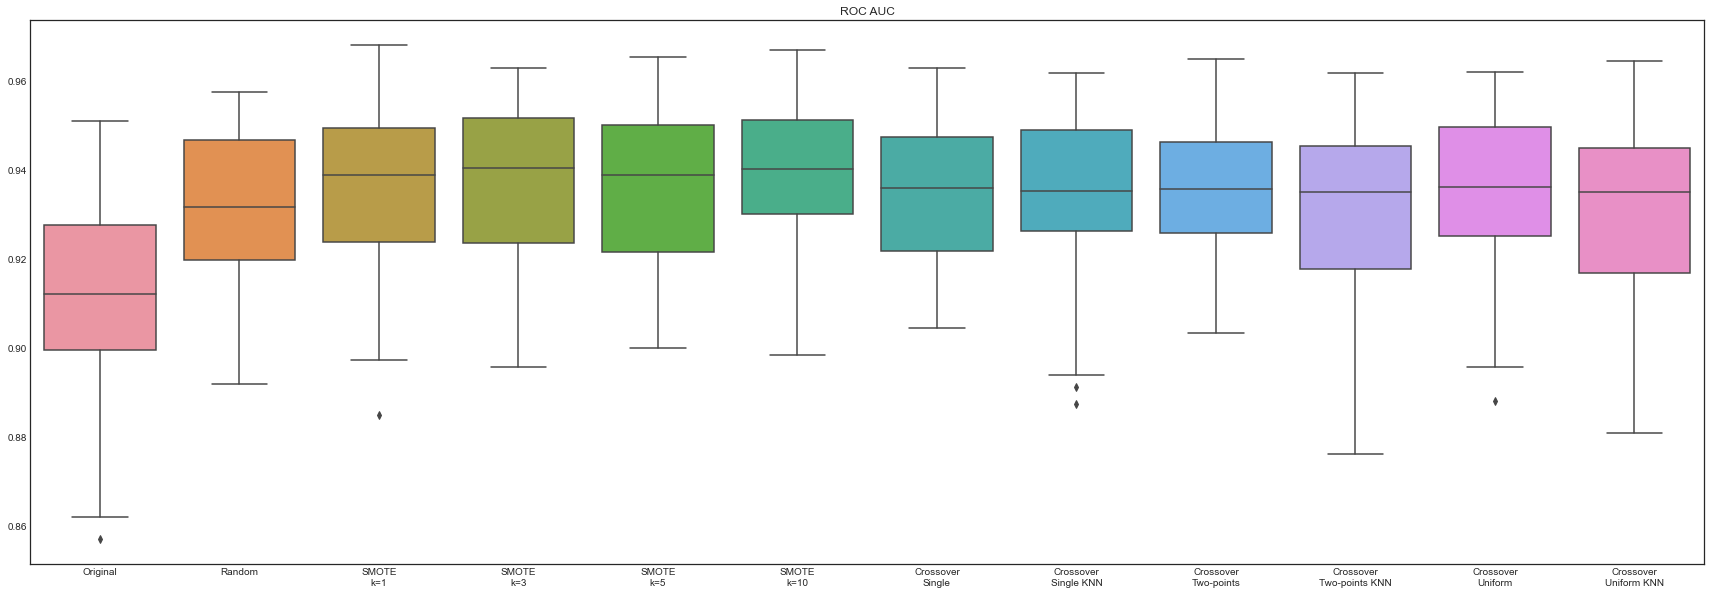

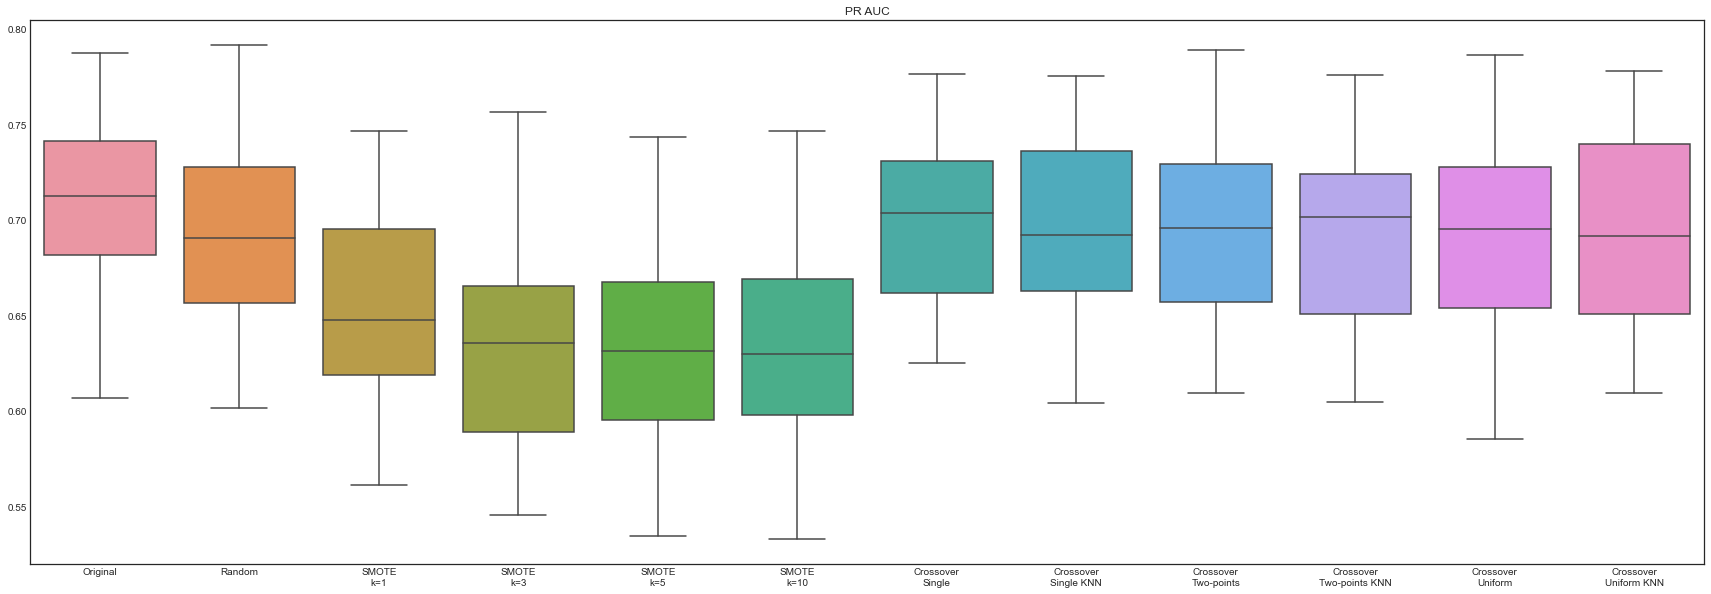

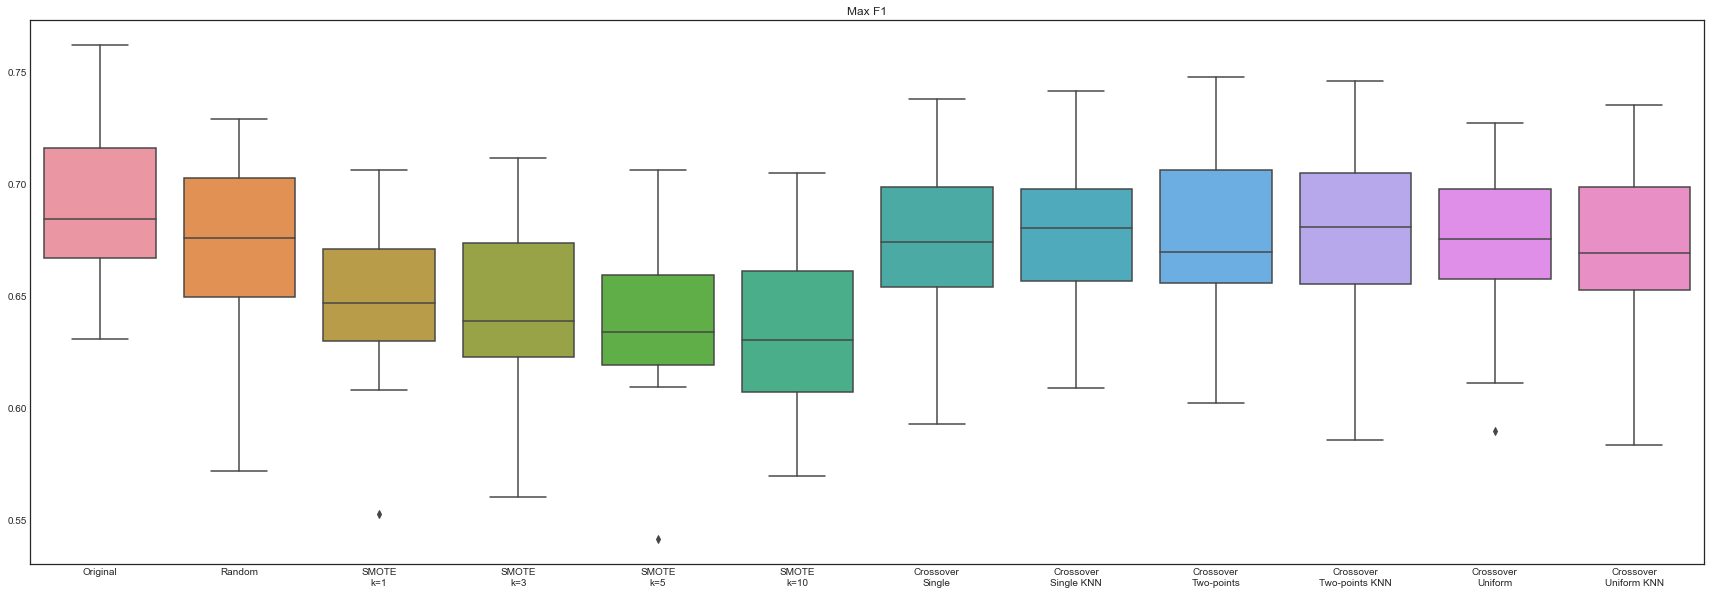

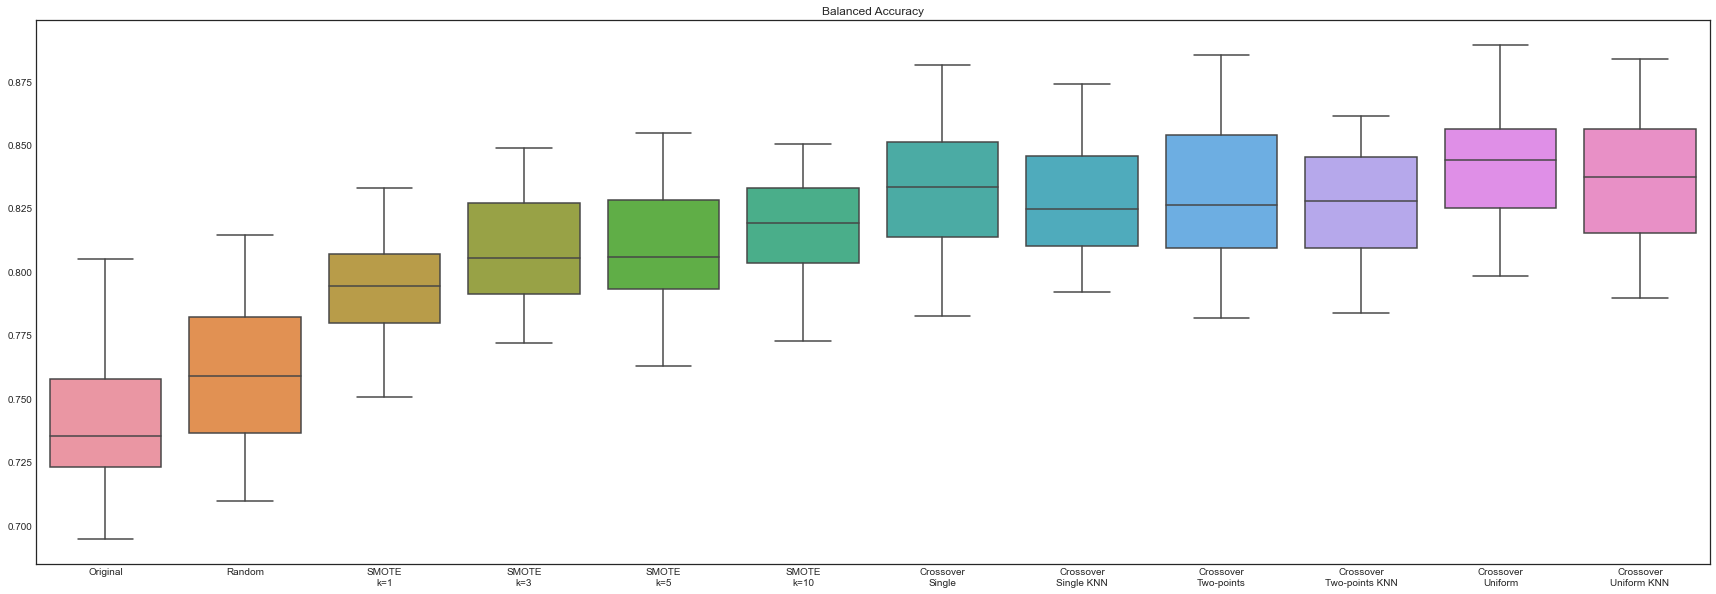

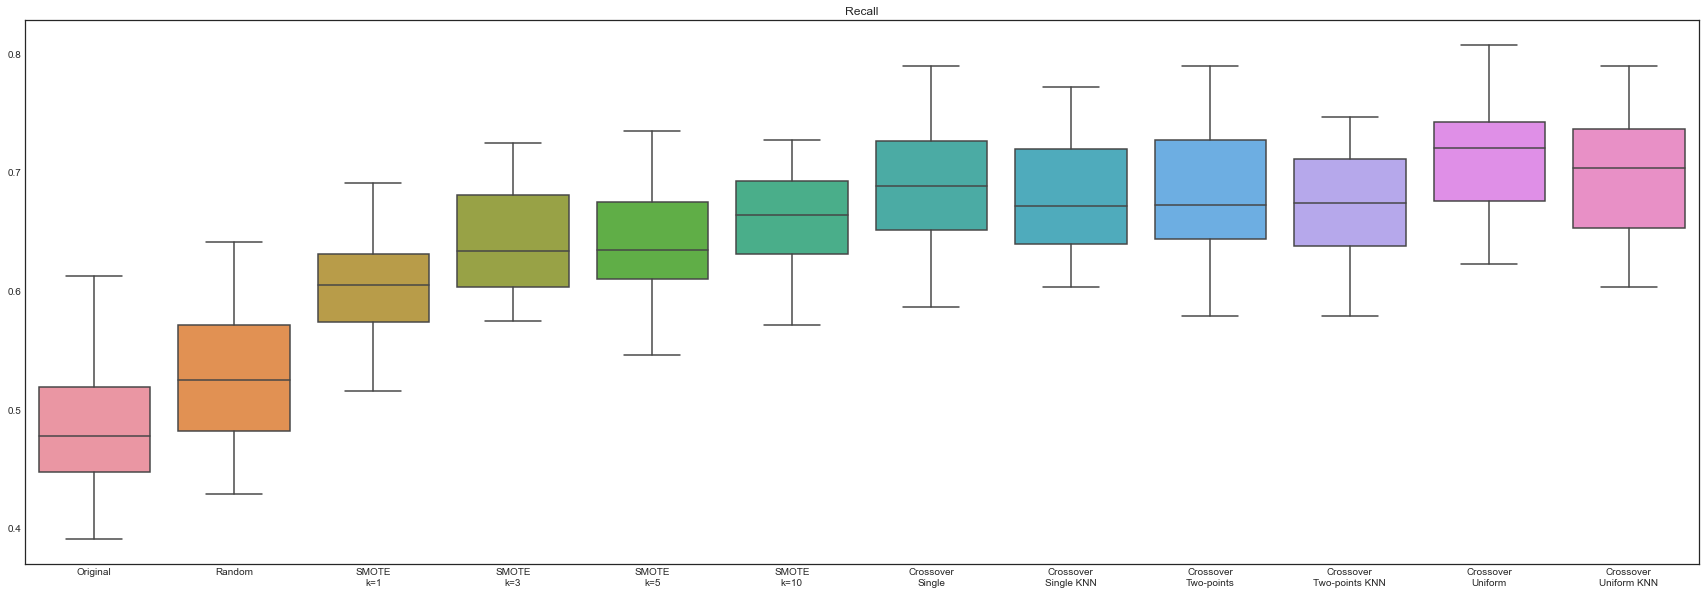

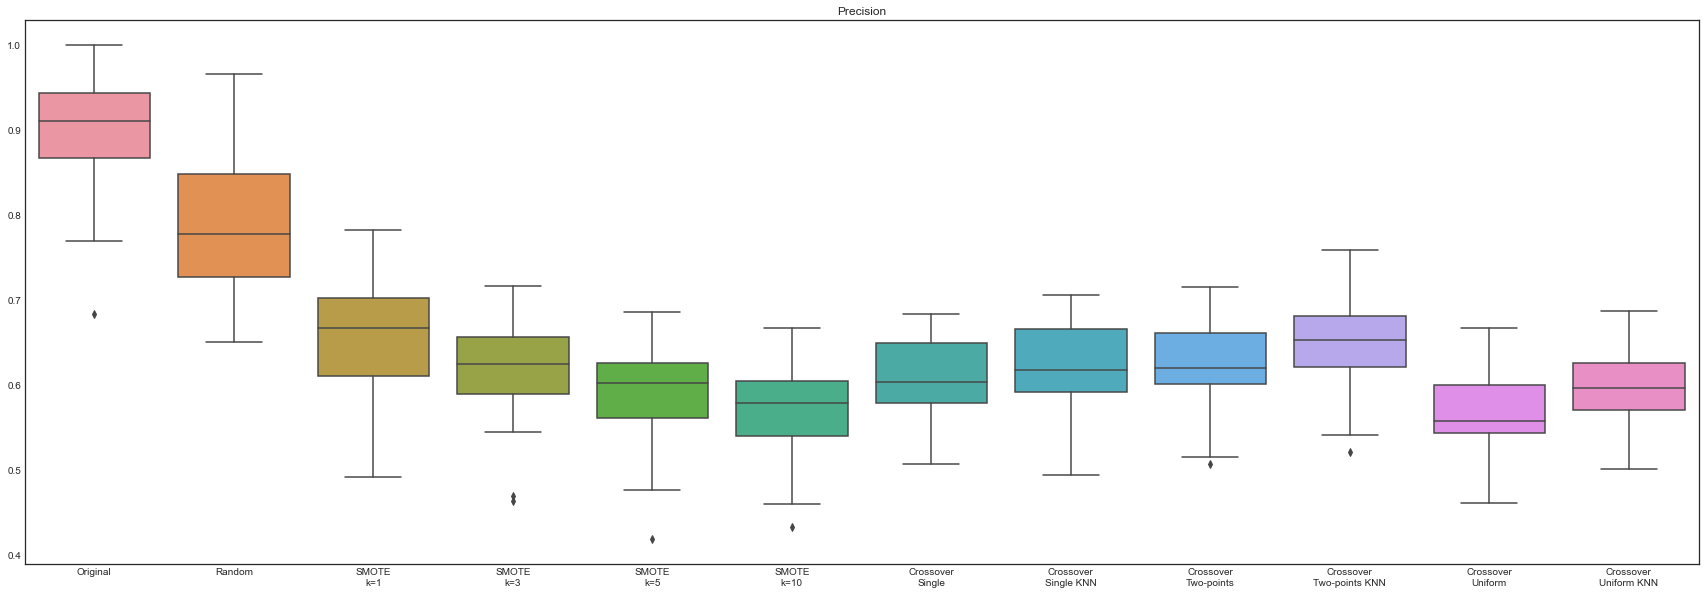

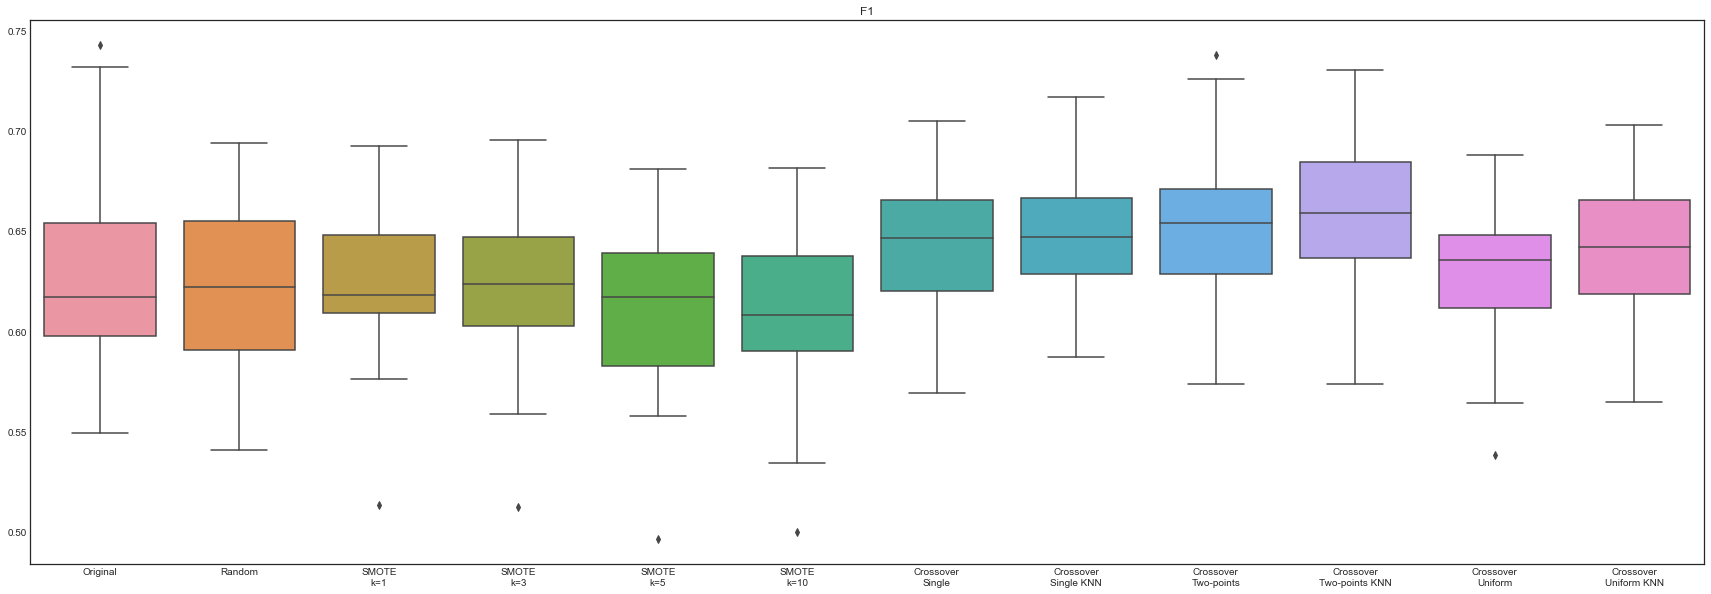

In [9]:
metrics = ["ROC AUC", "PR AUC", "Max F1", 
           "Balanced Accuracy", "Recall",
           "Precision", "F1"]

for metric in metrics:
    plt.figure(figsize=(30, 10))

    data = pd.DataFrame(data={
        "Original": results_original[metric], 
        "Random": results_random[metric],
        "SMOTE\nk=1": results_smote_1[metric],
        "SMOTE\nk=3": results_smote_3[metric],
        "SMOTE\nk=5": results_smote_5[metric],
        "SMOTE\nk=10": results_smote_10[metric],
        "Crossover\nSingle": results_singlex[metric],
        "Crossover\nSingle KNN": results_singlex_knn[metric],
        "Crossover\nTwo-points": results_twox[metric],
        "Crossover\nTwo-points KNN": results_twox_knn[metric],
        "Crossover\nUniform": results_uniformx[metric],
        "Crossover\nUniform KNN": results_uniformx_knn[metric],
    })

    sns.boxplot(data=data)
    plt.title(metric)
    plt.show()